<a href="https://colab.research.google.com/github/HssngH/ToBigs18/blob/main/KNN_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("./drive/MyDrive/Colab Notebooks/ToBigs/week4_KNN&neighbors/blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [6]:
# 변수별 값 분포 확인하기
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print('-----------------------')

User_ID
1002063    12
1005795    12
1001980    11
1004344    11
1006036    10
           ..
1004980     1
1004385     1
1004138     1
1002648     1
1000837     1
Name: User_ID, Length: 2656, dtype: int64
-----------------------
Product_ID
P00265242    21
P00220442    16
P00114942    15
P00010742    15
P00148642    15
             ..
P00072342     1
P00037842     1
P00207042     1
P00129742     1
P00358242     1
Name: Product_ID, Length: 1797, dtype: int64
-----------------------
Gender
M    3765
F    1233
Name: Gender, dtype: int64
-----------------------
Age
26-35    1996
36-45    1000
18-25     906
46-50     414
51-55     350
55+       195
0-17      137
Name: Age, dtype: int64
-----------------------
Occupation
4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18
Name: Occupation, dtype: int64
-----------------------
City_Categor

In [7]:
df.isnull().sum()
# Product_Category_2와 Product_Category_3 결측치 존재 확인

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [9]:
# Product_Category_3 값은 결측치 비중 높아서 삭제
df = df.drop("Product_Category_3", axis=1)

# Product_Category_2 값은 평균으로 대체(삭제하기엔 비중이 높지 않음)
df['Product_Category_2'] = df['Product_Category_2'].fillna(df['Product_Category_2'].mean())

df.isnull().sum()
# 결측치 존재하지 않음

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

In [10]:
# User_ID삭제
df = df.drop("User_ID", axis=1)

In [15]:
# Product_ID 를 원핫인코딩하기에는 값 종류가 너무 많음
print(len(df['Product_ID'].unique()))
df['Product_ID'].unique()

# 앞의 5자리까지 묶어서 인코딩하기로 함
df['Product_ID'] = df['Product_ID'].map(lambda x:x[:4])
print(len(df['Product_ID'].unique()))

5
5


In [16]:
# 원핫인코딩 전, 변수가 obj인 list 생성해주기
int_list = []
obj_list = []

for col in df.columns:
    if df[col].dtype != 'object':
        int_list.append(col)
    else:
        obj_list.append(col)

print('DataType : int', int_list)

DataType : int ['Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Purchase']


In [19]:
# 원-핫 인코딩 진행
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder().fit(df[obj_list])     # One-Hot-Encoding
encoder.get_feature_names(obj_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['Product_ID_P000', 'Product_ID_P001', 'Product_ID_P002',
       'Product_ID_P003', 'Product_ID_P009', 'Gender_F', 'Gender_M',
       'Age_0-17', 'Age_18-25', 'Age_26-35', 'Age_36-45', 'Age_46-50',
       'Age_51-55', 'Age_55+', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Stay_In_Current_City_Years_0',
       'Stay_In_Current_City_Years_1', 'Stay_In_Current_City_Years_2',
       'Stay_In_Current_City_Years_3', 'Stay_In_Current_City_Years_4+'],
      dtype=object)

In [20]:
encoder_d = pd.DataFrame(encoder.transform(df[obj_list]).toarray(), index = df.index, columns = encoder.get_feature_names(obj_list))

df_fin = pd.concat([df, encoder_d], sort = False, axis = 1)
df_fin = df_fin.drop(['Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2'], axis = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
df_fin.head()

,Gender,Marital_Status,Purchase,Product_ID_P000,Product_ID_P001,Product_ID_P002,Product_ID_P003,Product_ID_P009,Gender_F,Gender_M,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,F,0,2010,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,F,0,4483,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,F,0,7696,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,F,0,16429,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,F,0,5780,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


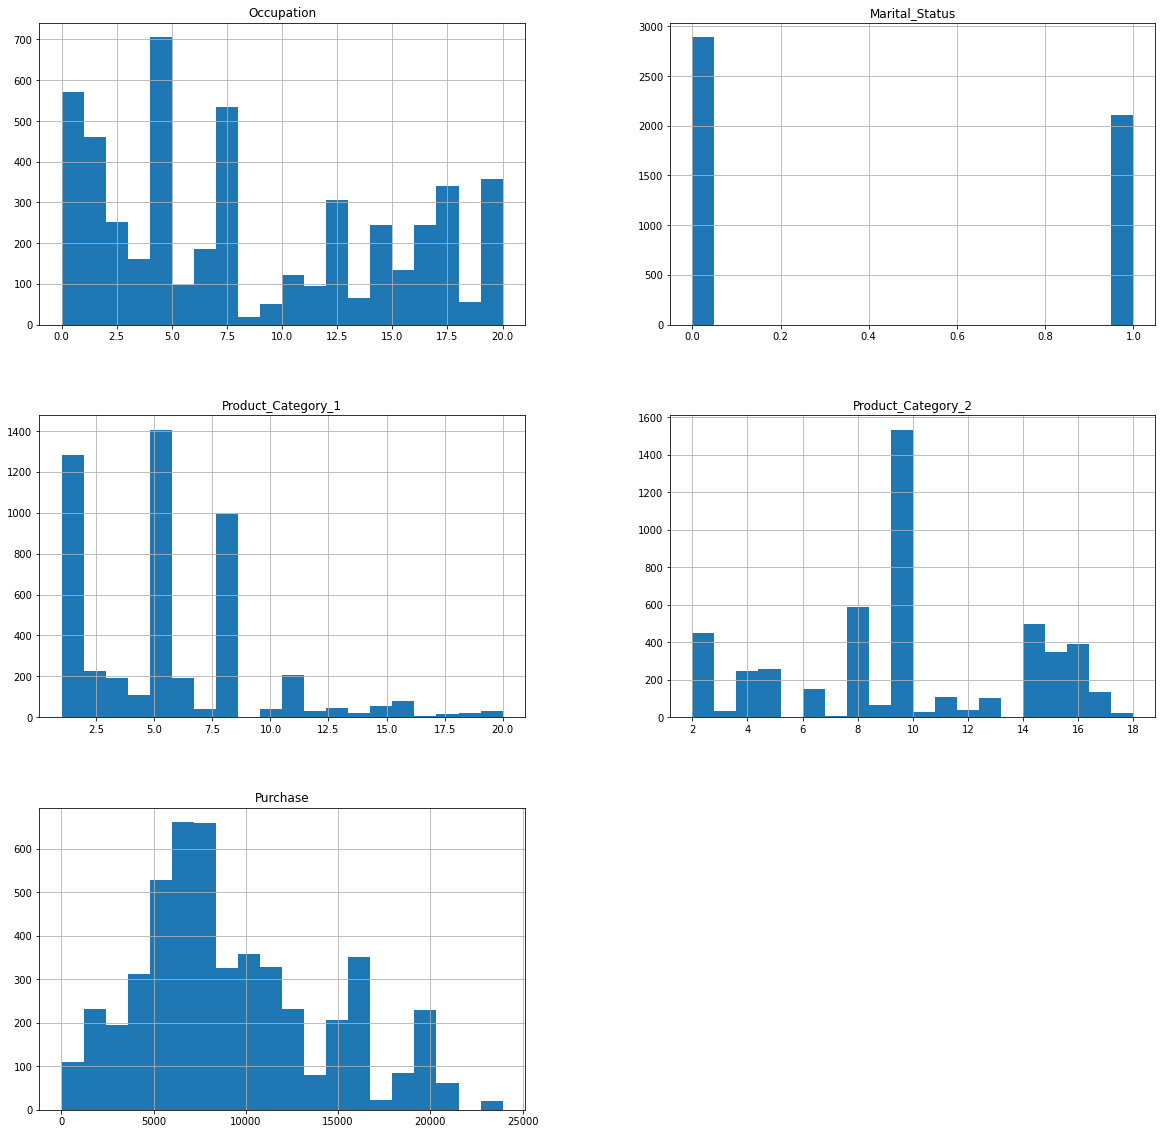

In [22]:
df.hist(bins=20, figsize=(20,20));
# 변수 값별 히스토그램 확인

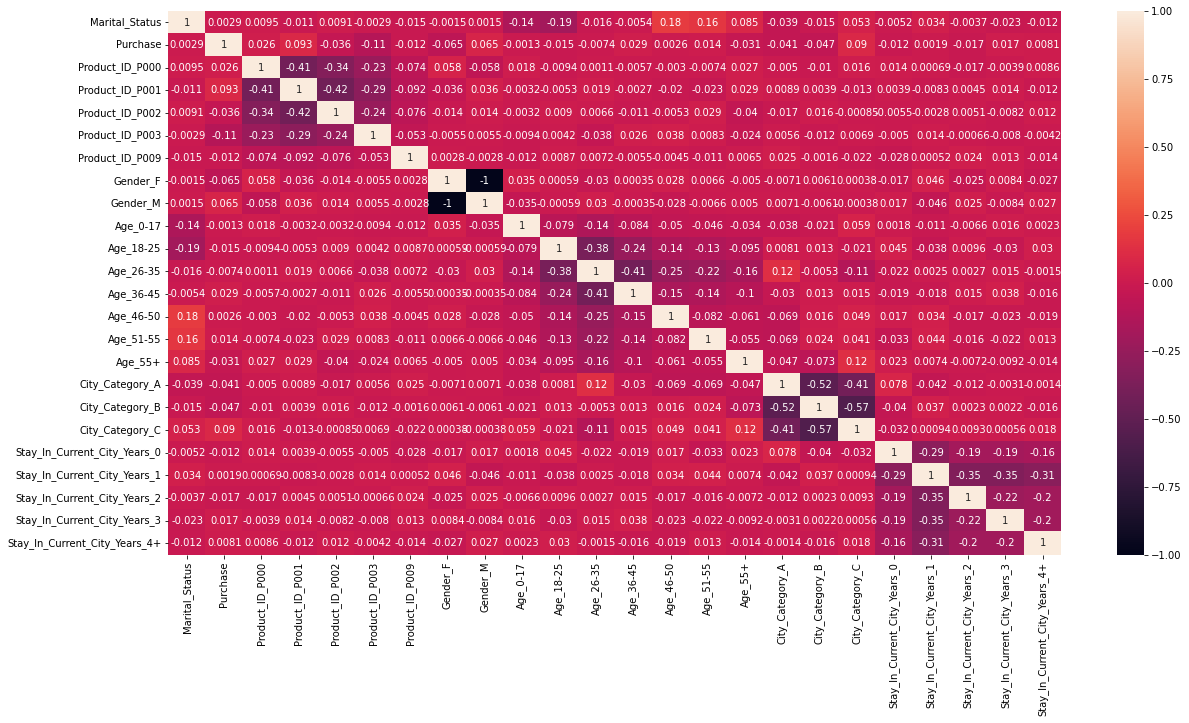

In [23]:
# 상관관계
import matplotlib.pyplot as plt
import seaborn as sns

df_fin.corr()
plt.figure(figsize=(20,10))
sns.heatmap(df_fin.corr(),annot=True)
# 변수별 크게 상관관계가 있는 것 같지 않음

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [26]:
X = df_fin.drop(['Gender'], axis = 1) 
y = df_fin.Gender 

In [27]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit_transform(X)
X = pd.DataFrame(std.fit_transform(X), columns = X.columns)
X.head()

,Marital_Status,Purchase,Product_ID_P000,Product_ID_P001,Product_ID_P002,Product_ID_P003,Product_ID_P009,Gender_F,Gender_M,Age_0-17,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,-0.853356,-1.445300,1.751206,-0.713802,-0.587362,-0.409582,-0.129152,1.747435,-1.747435,5.956656,...,-0.274411,-0.201493,1.651384,-0.851956,-0.672042,-0.395148,-0.736609,-0.473392,2.122358,-0.417543
1,-0.853356,-0.950574,-0.571035,-0.713802,-0.587362,2.441516,-0.129152,1.747435,-1.747435,5.956656,...,-0.274411,-0.201493,1.651384,-0.851956,-0.672042,-0.395148,1.357573,-0.473392,-0.471174,-0.417543
2,-0.853356,-0.307810,1.751206,-0.713802,-0.587362,-0.409582,-0.129152,1.747435,-1.747435,5.956656,...,-0.274411,-0.201493,1.651384,-0.851956,-0.672042,-0.395148,1.357573,-0.473392,-0.471174,-0.417543
3,-0.853356,1.439236,-0.571035,1.400948,-0.587362,-0.409582,-0.129152,1.747435,-1.747435,5.956656,...,-0.274411,-0.201493,1.651384,-0.851956,-0.672042,-0.395148,-0.736609,-0.473392,2.122358,-0.417543
4,-0.853356,-0.691107,-0.571035,1.400948,-0.587362,-0.409582,-0.129152,1.747435,-1.747435,5.956656,...,-0.274411,-0.201493,1.651384,-0.851956,-0.672042,-0.395148,-0.736609,-0.473392,2.122358,-0.417543


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
print("Test Score : {:.3f}".format(knn.score(X_test, y_test)))

Test Score : 0.999
